This post was originally going to focus on using multivariate linear regression to model hourly, regional electricity load data until I noticed that some of the series that I was importing from EIA appeared to be contaminated with outliers and missing data. I started to spend a considerable amount of time scrubbing the data and decided to just turn the scrubbing exercise into its own post. Data scrubbing is not always the most rewarding task but I tried to put an interesting spin on this by playing around with an unsupervised machine learning technique that can be used for outlier detection. The goal is to come up with a method that would dynamically identify outliers on the fly.

In [1]:
import sys
sys.path.insert(0, '/home/johnr_000/jupyter_blog/jupyter_blog/scripts')
import eia_model as em
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from datetime import datetime

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
#variables to specify date range and frequency
api_key = 'Your Api Key'
start = '2015-12-01 01:00:00'
end = '2016-01-31 23:00:00'
freq = 'H'
# create list of series used for dictionary keys
keys = ['EBA.BPAT-ALL.D.H', 'EBA.PACE-ALL.D.H', 'EBA.PACW-ALL.D.H', 
        'EBA.PGE-ALL.D.H', 'EBA.PSEI-ALL.D.H', 'EBA.SCL-ALL.D.H']
# create dict of GetSeriesRange objects from series list
series_dict = {key: em.GetSeries(api_key=api_key, series_id=key, 
                                   start=start, end=end, freq=freq) for key in keys}

In [3]:
# loop over dictionary and print out full name of each series
for key in series_dict:
    print('{}: {}'.format(series_dict[key].data.series[0]['name'],key))

Demand for PacifiCorp East (PACE), Hourly: EBA.PACE-ALL.D.H
Demand for PacifiCorp West (PACW), Hourly: EBA.PACW-ALL.D.H
Demand for Bonneville Power Administration (BPAT), Hourly: EBA.BPAT-ALL.D.H
Demand for Seattle City Light (SCL), Hourly: EBA.SCL-ALL.D.H
Demand for Puget Sound Energy, Inc. (PSEI), Hourly: EBA.PSEI-ALL.D.H
Demand for Portland General Electric Company (PGE), Hourly: EBA.PGE-ALL.D.H


In [4]:
# all the dataframes have the same date range so we can concatenate in a loop
concat_df = pd.concat([series_dict[key].data.df for key in series_dict], axis=1)

In [5]:
# print out descriptive statistics for each series
for key in keys:
    print(key,
          "'\t\n mean :'{}".format(concat_df[key].mean()),
          "' median :'{}".format(concat_df[key].median()),
          "' min :'{}".format(concat_df[key].min()),
          "' max :'{}".format(concat_df[key].max())
          )

EBA.BPAT-ALL.D.H '	
 mean :'7059.477471418964 ' median :'7109.0 ' min :'5006 ' max :'9365
EBA.PACE-ALL.D.H '	
 mean :'-24706.174848688635 ' median :'5508.0 ' min :'-31990166 ' max :'59668
EBA.PACW-ALL.D.H '	
 mean :'4451.197713517148 ' median :'2709.0 ' min :'-6785 ' max :'2530003
EBA.PGE-ALL.D.H '	
 mean :'2579.9219905850705 ' median :'2646.0 ' min :'1730 ' max :'3472
EBA.PSEI-ALL.D.H '	
 mean :'3946.0661268556005 ' median :'4021.0 ' min :'2292.0 ' max :'5088.0
EBA.SCL-ALL.D.H '	
 mean :'1282.2589105581708 ' median :'1324.0 ' min :'868 ' max :'1654


In [6]:
# first pass filter out negatives and zeroes
for key in keys:
    concat_df[concat_df[key] < 0] = np.nan

for key in keys:
    print(key,
          "'\t\n mean :'{}".format(concat_df[key].mean()),
          "' median :'{}".format(concat_df[key].median()),
          "' min :'{}".format(concat_df[key].min()),
          "' max :'{}".format(concat_df[key].max())
          )

EBA.BPAT-ALL.D.H '	
 mean :'7057.380823767725 ' median :'7107.0 ' min :'5006.0 ' max :'9365.0
EBA.PACE-ALL.D.H '	
 mean :'5532.663065496286 ' median :'5508.0 ' min :'4108.0 ' max :'59668.0
EBA.PACW-ALL.D.H '	
 mean :'4478.549628629305 ' median :'2710.0 ' min :'1763.0 ' max :'2530003.0
EBA.PGE-ALL.D.H '	
 mean :'2578.5563808237675 ' median :'2643.0 ' min :'1730.0 ' max :'3472.0
EBA.PSEI-ALL.D.H '	
 mean :'3944.419376693767 ' median :'4017.5 ' min :'2292.0 ' max :'5088.0
EBA.SCL-ALL.D.H '	
 mean :'1281.6914247130317 ' median :'1322.0 ' min :'868.0 ' max :'1654.0


In [7]:
class PredictOutliers(object):
    
    def __init__(self, input_data, label, col1, col2, cont, rand):
        self.training_data = pd.DataFrame(input_data.loc[:,[col1, col2]])
        self.label = label
        self.index = input_data.index.values
        self.clf = self.fit_clf(cont, rand)
        self.pred_data = pd.concat([self.training_data, self.create_predictions()], axis=1)

    def fit_clf(self, cont, rand):
        clf = IsolationForest(contamination=cont, random_state=rand)
        return clf.fit(self.training_data.values)
        
    def create_predictions(self):
        opred = self.clf.predict(self.training_data.values)
        dfunc = self.clf.decision_function(self.training_data.values)
        l1 = '{}{}'.format(self.label, '_opred')
        l2 = '{}{}'.format(self.label, '_dfunc')
        return pd.DataFrame(np.column_stack((opred, dfunc)), index=self.index, columns=[l1, l2])

In [8]:
# Interpolate missing values and create hourly column from index
concat_df = concat_df.interpolate(method='linear')
concat_df.loc[:,'HOUR'] = pd.to_datetime(concat_df.index).hour
# Create a dictionary of predictions for each series
pred_dict = {key: PredictOutliers(concat_df, key, 'HOUR', key, .01, 1234) for key in keys}

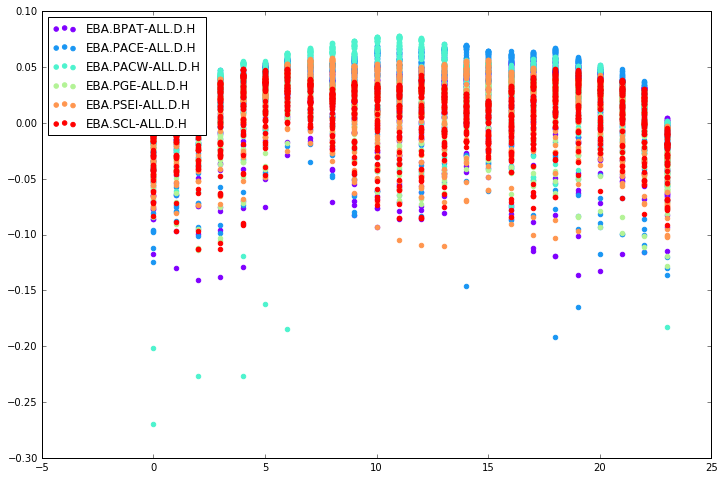

In [9]:
# Plot the decision function for each series
fig = plt.figure(figsize=(12, 8), dpi=100)
colors = plt.cm.rainbow(np.linspace(0, 1, len(keys)))
for key, color in zip(keys, colors):
    pred_data = pred_dict[key].pred_data
    plt.scatter(pred_data['HOUR'].values, pred_data['{}{}'.format(key, '_dfunc')].values, 
                color=color, label=key)
legend = plt.legend(loc='upper left')
plt.show()

In [10]:
# Output all observations that are predicted to be outliers
for key in keys:
    pred_df = pred_dict[key].pred_data
    print(key + ': \n',
          pred_df[pred_df[key + '_opred'] == -1][[key,key + '_dfunc']].sort_values(by = key + '_dfunc')
          )

EBA.BPAT-ALL.D.H: 
                      EBA.BPAT-ALL.D.H  EBA.BPAT-ALL.D.H_dfunc
2016-01-04 02:00:00          9267.000                  -0.141
2016-01-04 03:00:00          9152.000                  -0.138
2016-01-03 19:00:00          9266.000                  -0.137
2016-01-03 20:00:00          9148.000                  -0.133
2016-01-04 01:00:00          8981.000                  -0.130
2016-01-04 04:00:00          9004.000                  -0.129
2016-01-03 18:00:00          9365.000                  -0.119
2016-01-02 18:00:00          9298.000                  -0.119
2016-01-03 21:00:00          8971.000                  -0.117
2016-01-04 00:00:00          8656.000                  -0.117
2016-01-03 22:00:00          8807.000                  -0.115
2016-01-03 23:00:00          8628.000                  -0.115
2016-01-02 17:00:00          9284.000                  -0.114
2016-01-03 17:00:00          9256.000                  -0.112
2016-01-02 19:00:00          9016.000             

In [11]:
# Based on output filter out any values where decision function is less than 0.16 and interpolate
for key in keys:
     pred_dict[key].pred_data.loc[pred_dict[key].pred_data[key + '_dfunc'] <= -.16, key] = np.nan
     pred_dict[key].pred_data.loc[:,key] = pred_dict[key].pred_data.loc[:,key].interpolate(method='linear')   

In [12]:
# print out interpolated outliers
for key in keys:
    pred_df = pred_dict[key].pred_data
    print(key + ': \n',
          pred_df[pred_df[key + '_dfunc'] <= -.16][[key,key + '_dfunc']].sort_values(by = key + '_dfunc')
          )

EBA.BPAT-ALL.D.H: 
 Empty DataFrame
Columns: [EBA.BPAT-ALL.D.H, EBA.BPAT-ALL.D.H_dfunc]
Index: []
EBA.PACE-ALL.D.H: 
                      EBA.PACE-ALL.D.H  EBA.PACE-ALL.D.H_dfunc
2015-12-22 18:00:00          5187.667                  -0.192
2015-12-22 19:00:00          5185.333                  -0.165
EBA.PACW-ALL.D.H: 
                      EBA.PACW-ALL.D.H  EBA.PACW-ALL.D.H_dfunc
2016-01-11 00:00:00          2604.000                  -0.270
2015-12-08 04:00:00          2734.500                  -0.227
2015-12-09 02:00:00          2666.000                  -0.227
2016-01-06 00:00:00          3039.667                  -0.202
2016-01-12 06:00:00          3757.222                  -0.185
2016-01-05 23:00:00          3013.333                  -0.183
2016-01-12 05:00:00          4974.444                  -0.162
EBA.PGE-ALL.D.H: 
 Empty DataFrame
Columns: [EBA.PGE-ALL.D.H, EBA.PGE-ALL.D.H_dfunc]
Index: []
EBA.PSEI-ALL.D.H: 
 Empty DataFrame
Columns: [EBA.PSEI-ALL.D.H, EBA.PSEI-ALL.D.H_dfun

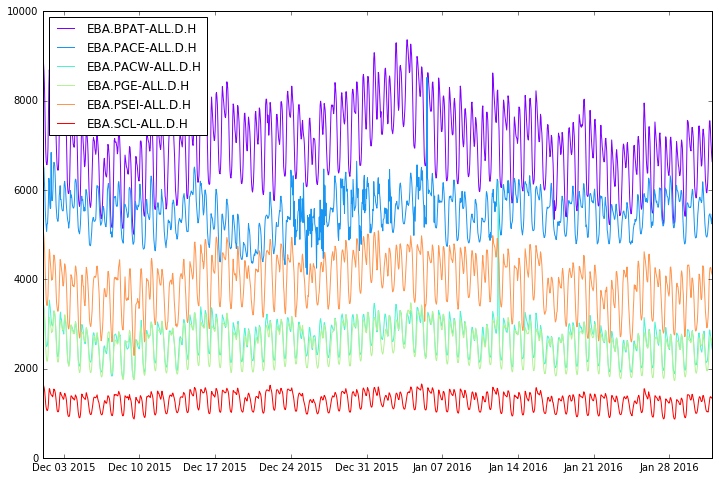

In [13]:
# Plot hourly load data
fig = plt.figure(figsize=(12, 8), dpi=100)
colors = plt.cm.rainbow(np.linspace(0, 1, len(keys)))
for key, color in zip(keys, colors):
    plt.plot(pd.to_datetime(pred_dict[key].pred_data.index), pred_dict[key].pred_data.loc[:,key].values, 
                color=color, label=key)
legend = plt.legend(loc='upper left')
plt.show()